# Monte Carlo Financial Simulation of Investment Paths of Returns with Normal Distribution

## Step 0: Declare global variables and inputs, fix the random seed for debug only

In [15]:
# Define expected return and volatility based on risk level
risk_params = {
    1: {"expected_return": 0.038 / 12, "volatility": 0.049 / 12},
    2: {"expected_return": 0.056 / 12, "volatility": 0.07 / 12},
    3: {"expected_return": 0.066 / 12, "volatility": 0.097 / 12},
    4: {"expected_return": 0.072 / 12, "volatility": 0.177 / 12},
    5: {"expected_return": 0.093 / 12, "volatility": 0.204 / 12},
}

In [16]:
# Inputs
target_amount_input = 450000
current_lumpsum_input = 10000
months_input = 396
risk_level_input = 3
upper_percentile_input = 95
lower_percentile_input = 100 - upper_percentile_input
num_simulations_input = 100000

In [17]:
import numpy as np

# This line must be removed in production
# np.random.seed(0)

## Step 1: Find the median monthly contribution required to reach the target amount based on the risk level


### 1.1 Perform simulation based on the random normal distribution of returns in each month for each independent simulation


In [18]:
def monte_carlo_simulation(target_amount, current_lumpsum, monthly_returns, num_simulations, upper_percentile,
                           lower_percentile):
    # Calculate compounded growth factors for the lump sum
    compounded_growth = np.cumprod(1 + monthly_returns, axis=1)
    future_lumpsums = current_lumpsum * compounded_growth[:, -1]

    # Compute future value factors for contributions
    one_plus_returns = 1 + monthly_returns
    reversed_one_plus_returns = np.flip(one_plus_returns, axis=1)
    cumprod_reversed = np.cumprod(reversed_one_plus_returns, axis=1)
    shifted_cumprod = np.hstack([np.ones((num_simulations, 1)), cumprod_reversed[:, :-1]])
    future_value_factors = np.flip(shifted_cumprod, axis=1)

    # Sum the future value factors for each simulation
    fv_factors_sums = future_value_factors.sum(axis=1)

    # Compute required monthly contributions
    required_contributions = (target_amount - future_lumpsums) / fv_factors_sums

    contributions_values = required_contributions[:,
                           np.newaxis] * future_value_factors  # Shape: (num_valid_simulations, months)
    contributions_cumulative = np.cumsum(contributions_values, axis=1)  # Shape: (num_valid_simulations, months)

    portfolio_values = current_lumpsum * compounded_growth + contributions_cumulative  # Shape: (num_valid_simulations, months)

    contribution_percentiles = np.percentile(required_contributions, [lower_percentile, 50, upper_percentile])
    portfolio_percentiles = np.percentile(portfolio_values, [lower_percentile, 50, upper_percentile], axis=0)
    return contribution_percentiles, portfolio_percentiles

In [19]:
import time

expected_return = risk_params[risk_level_input]["expected_return"]
volatility = risk_params[risk_level_input]["volatility"]
start_time = time.time()
contribution_percentiles_output, portfolio_percentiles_output = monte_carlo_simulation(target_amount_input,
                                                                                       current_lumpsum_input,
                                                                                       np.random.normal(expected_return,
                                                                                                        volatility,
                                                                                                        (
                                                                                                            num_simulations_input,
                                                                                                            months_input)),
                                                                                       num_simulations_input,
                                                                                       upper_percentile_input,
                                                                                       lower_percentile_input)
end_time = time.time()

In [20]:
print(f"Monte Carlo simulation took {end_time - start_time:.2f} seconds to run.")
print(f"Risk Level {risk_level_input}:")
print(f"  Mid-Point Monthly Contribution: ${contribution_percentiles_output[1]:.2f}")
print(
    f"  {upper_percentile_input}% Confidence Range Monthly Contribution: ${contribution_percentiles_output[0]:.2f} - ${contribution_percentiles_output[2]:.2f}")

Monte Carlo simulation took 1.56 seconds to run.
Risk Level 3:
  Mid-Point Monthly Contribution: $258.54
  95% Confidence Range Monthly Contribution: $198.81 - $328.92


### 1.2 Plot the cumulative contributions over time with fixed FV of target amount

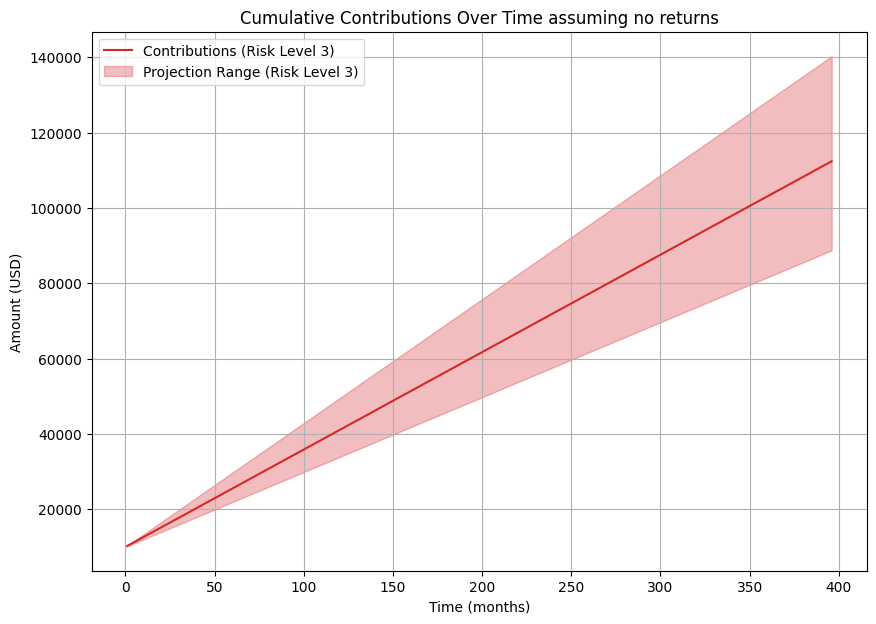

In [21]:
import matplotlib.pyplot as plt


# Plotting
def plot_cumulative_contribution(contribution_percentiles, months, current_lumpsum):
    plt.figure(figsize=(10, 7))

    for risk_level, data in contribution_percentiles.items():
        projection_min = data[0]
        projection_max = data[2]
        monthly_contribution = data[1]

        time_range = np.arange(1, months + 1)
        contributions = current_lumpsum + np.cumsum([monthly_contribution] * months)
        contribution_min = current_lumpsum + np.cumsum([projection_min] * months)
        contribution_max = current_lumpsum + np.cumsum([projection_max] * months)

        plt.plot(time_range, contributions, label=f'Contributions (Risk Level {risk_level})', color=f'C{risk_level}')
        plt.fill_between(time_range, contribution_min, contribution_max, alpha=0.3, color=f'C{risk_level}',
                         label=f'Projection Range (Risk Level {risk_level})')

    plt.xlabel('Time (months)')
    plt.ylabel('Amount (USD)')
    plt.title('Cumulative Contributions Over Time assuming no returns')
    plt.legend()
    plt.grid(True)
    plt.show()


# Call the plotting function
plot_cumulative_contribution({risk_level_input: contribution_percentiles_output}, months_input, current_lumpsum_input)

### 1.3 Plot the projected portfolio value over time with fixed FV of target amount

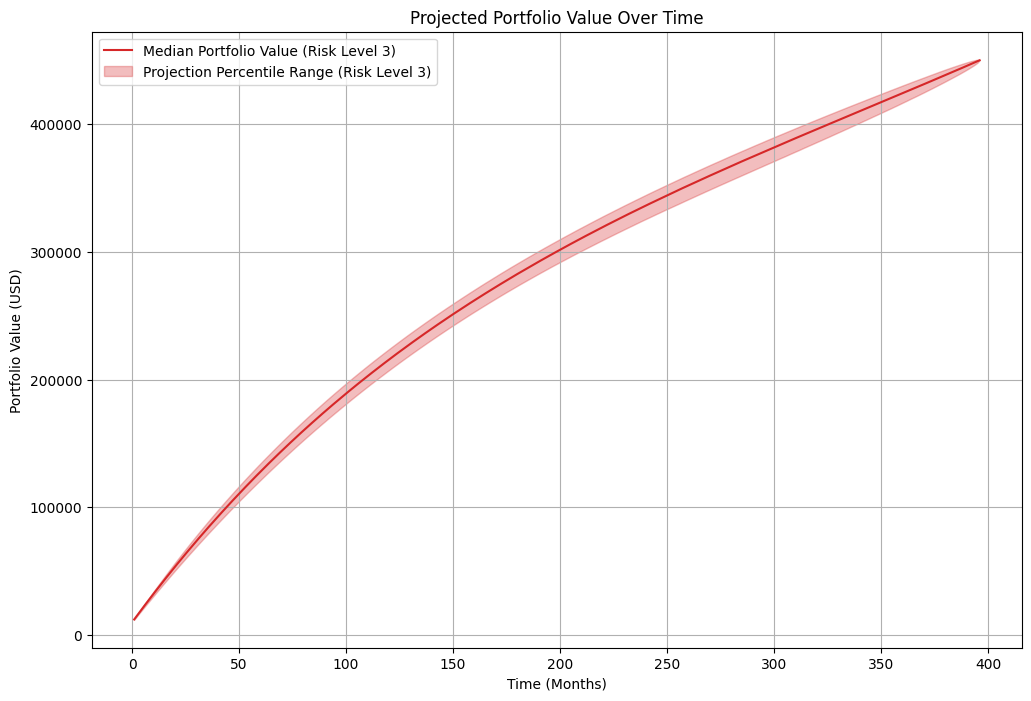

In [22]:
def plot_portfolio_value(portfolio_percentiles, months):
    for risk_level, data in portfolio_percentiles.items():
        percentile_lower, percentile_50th, percentile_upper = data
        time_range = np.arange(1, months + 1)
        plt.figure(figsize=(12, 8))
        plt.plot(time_range, percentile_50th, label=f"Median Portfolio Value (Risk Level {risk_level})",
                 color=f'C{risk_level}')
        plt.fill_between(time_range, percentile_lower, percentile_upper, color=f'C{risk_level}', alpha=0.3,
                         label=f"Projection Percentile Range (Risk Level {risk_level})")
        plt.xlabel('Time (Months)')
        plt.ylabel('Portfolio Value (USD)')
        plt.title('Projected Portfolio Value Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()


# Call the plotting function
plot_portfolio_value({risk_level_input: portfolio_percentiles_output}, months_input)

## Step 2: Fix the monthly contribution amount to what we find in Step 1, and calculate the FV of target amount based on random investment paths

### 2.1 Simulate the portfolio with fixed monthly contribution

In [23]:
def simulate_portfolio_with_fixed_contribution(current_lumpsum, monthly_returns,
                                               fixed_monthly_contribution):
    cumulative_returns = np.cumprod(1 + monthly_returns, axis=1)
    
    print(cumulative_returns.shape)

    # Shift one month to exclude growth from period t which has not occurred yet at the time of contribution
    multipliers = np.ones_like(cumulative_returns)
    multipliers[:, 1:] = cumulative_returns[:, :-1]

    # Compute the future value of each contribution
    contributions_value = fixed_monthly_contribution * multipliers

    # Compute cumulative contributions
    contributions_cumulative = np.cumsum(contributions_value, axis=1)

    # Compute portfolio values
    portfolio_values = current_lumpsum * cumulative_returns + contributions_cumulative
    
    print(portfolio_values.shape)

    return portfolio_values

In [24]:
def plot_portfolio_value_fixed(portfolio_values, target_amount, fixed_monthly_contribution):
    # Calculate percentiles over time
    percentiles = [5, 10, 25, 50, 75, 90, 95]
    portfolio_percentiles = np.percentile(portfolio_values, percentiles, axis=0)

    # Unpack the calculated percentiles
    percentile_5th, percentile_10th, percentile_25th, percentile_50th, percentile_75th, percentile_90th, percentile_95th = portfolio_percentiles

    # Time array
    months = portfolio_values.shape[1]
    time_range = np.arange(1, months + 1)

    plt.figure(figsize=(12, 8))

    # Plot the median portfolio value
    plt.plot(time_range, percentile_50th, label="Median Portfolio Value", color='blue', linewidth=2)

    # Plot percentile lines
    plt.plot(time_range, percentile_5th, linestyle='--', color='grey', label='5th Percentile')
    plt.plot(time_range, percentile_95th, linestyle='--', color='grey', label='95th Percentile')
    plt.plot(time_range, percentile_10th, linestyle='--', color='green', label='10th Percentile')
    plt.plot(time_range, percentile_90th, linestyle='--', color='green', label='90th Percentile')
    plt.plot(time_range, percentile_25th, linestyle='--', color='orange', label='25th Percentile')
    plt.plot(time_range, percentile_75th, linestyle='--', color='orange', label='75th Percentile')

    # Fill between percentiles to create shaded areas
    plt.fill_between(time_range, percentile_25th, percentile_75th, color='orange', alpha=0.2,
                     label='Inter quartile Range (25th - 75th Percentile)')
    plt.fill_between(time_range, percentile_10th, percentile_90th, color='green', alpha=0.1,
                     label='10th - 90th Percentile Range')
    plt.fill_between(time_range, percentile_5th, percentile_95th, color='grey', alpha=0.05,
                     label='5th - 95th Percentile Range')

    # Plot the target amount line
    plt.axhline(y=target_amount, color='red', linestyle='--', label='Target Amount')

    # Labels and title
    plt.xlabel('Time (Months)')
    plt.ylabel('Portfolio Value (USD)')
    plt.title(
        f'Projected Portfolio Value Over Time with Fixed Monthly Contribution of ${fixed_monthly_contribution:.2f}')

    # Legend and grid
    plt.legend()
    plt.grid(True)
    plt.show()


### 2.2 Plot the Projected Portfolio Value Over Time with Fixed Monthly Contribution from Median in Step 1


(100000, 396)
(100000, 396)


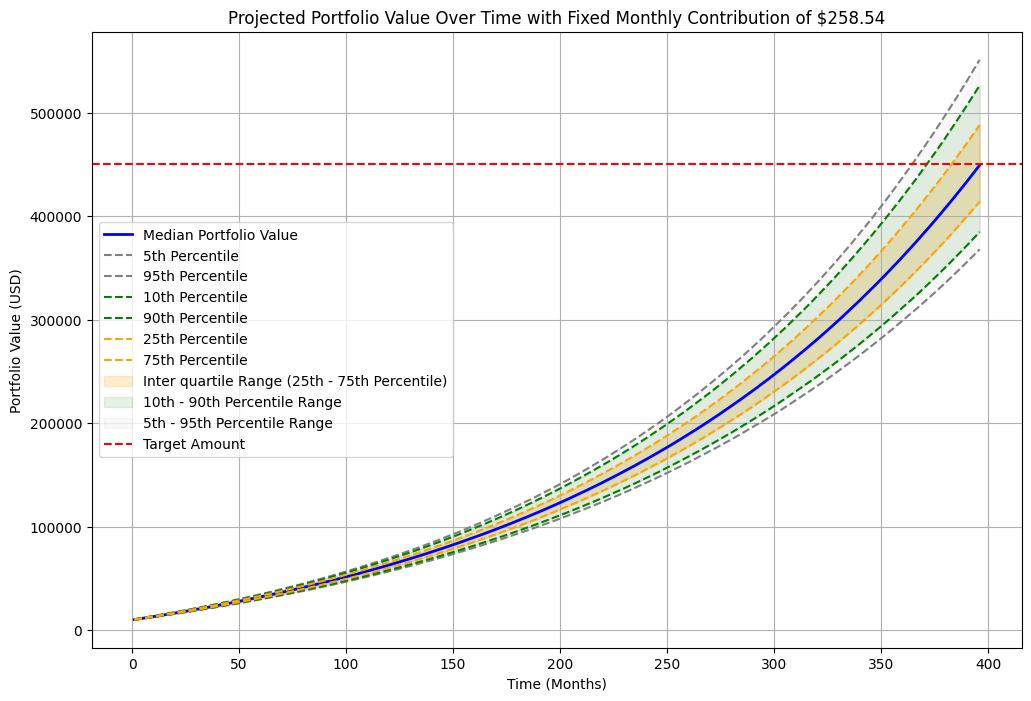

In [25]:
# Simulate the portfolio with the fixed contribution from mid-point from Step 1
portfolio_values_fixed = simulate_portfolio_with_fixed_contribution(
    current_lumpsum_input,
    np.random.normal(expected_return, volatility, (num_simulations_input, months_input)),
    contribution_percentiles_output[1]
)
# Call the plotting function
plot_portfolio_value_fixed(portfolio_values_fixed, target_amount_input, contribution_percentiles_output[1])

### 2.3 Plot the Projected Portfolio Value Over Time with Fixed Monthly Contribution from Lower Percentiles in Step 1

(100000, 396)
(100000, 396)


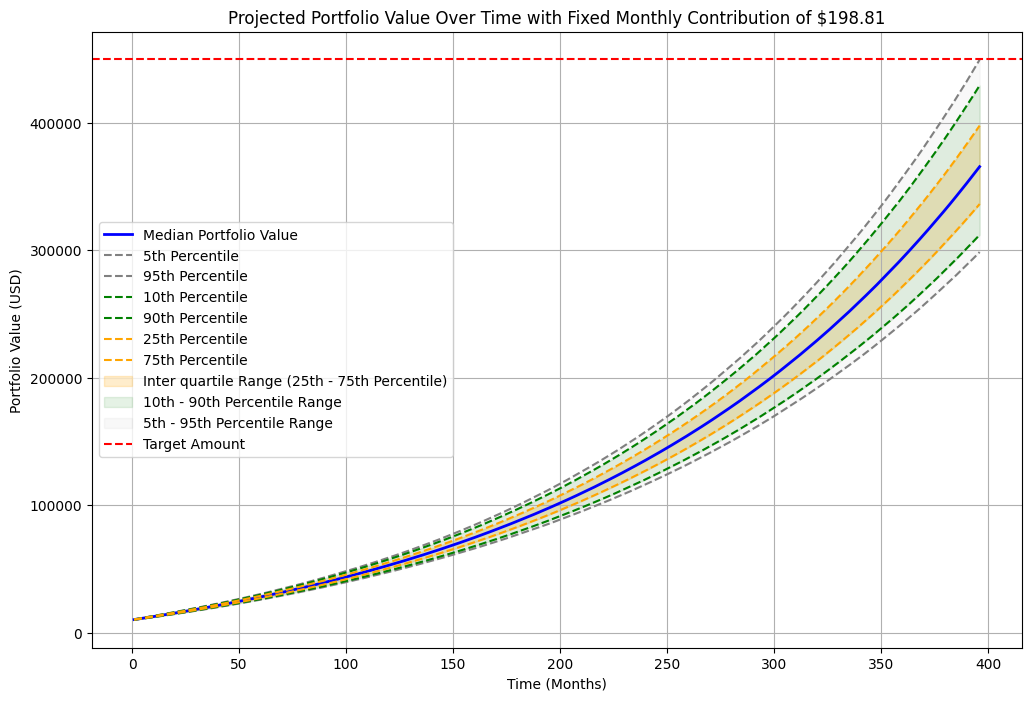

In [26]:
# Simulate the portfolio with the fixed contribution from lower percentile from Step 1
portfolio_values_fixed = simulate_portfolio_with_fixed_contribution(
    current_lumpsum_input,
    np.random.normal(expected_return, volatility, (num_simulations_input, months_input)),
    contribution_percentiles_output[0]
)
# Call the plotting function
plot_portfolio_value_fixed(portfolio_values_fixed, target_amount_input, contribution_percentiles_output[0])

### 2.4 Plot the Projected Portfolio Value Over Time with Fixed Monthly Contribution from Upper Percentiles in Step 1

(100000, 396)
(100000, 396)


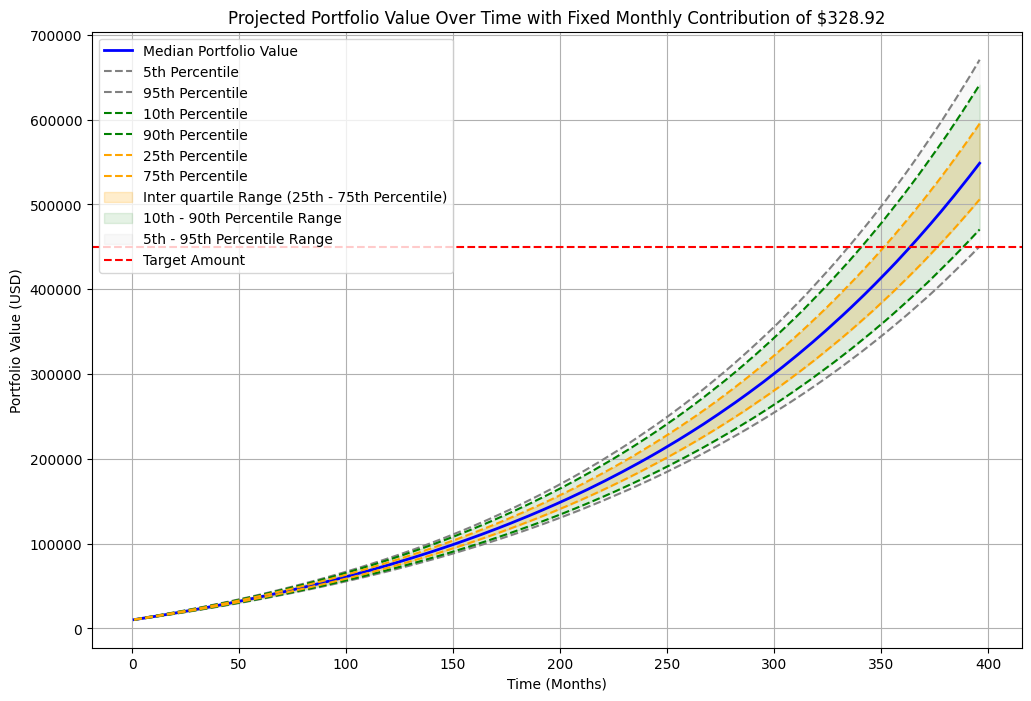

In [27]:
# Simulate the portfolio with the fixed contribution from upper percentile from Step 1
portfolio_values_fixed = simulate_portfolio_with_fixed_contribution(
    current_lumpsum_input,
    np.random.normal(expected_return, volatility, (num_simulations_input, months_input)),
    contribution_percentiles_output[2]
)
# Call the plotting function
plot_portfolio_value_fixed(portfolio_values_fixed, target_amount_input, contribution_percentiles_output[2])

In [28]:
import multiprocessing

print(multiprocessing.cpu_count())


12
